Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
from systole.detection import oxi_peaks, rr_artefacts

sns.set_context('talk')

The Heartbeat Counting task was analyzed using the `reports_HBC.py`. Reports are generated from the `HeartBEatCounting.ipynb` file and stored in `./data/raw/HBC/`
By examining manually these reports, it was decided to exclude the following participants due to noisy recorded PPG signal during the task.

In [2]:
remove = ['sub_0030', 'sub_0037', 'sub_0075', 'sub_0106', 'sub_0126', 'sub_0165', 'sub_0175']

# HBC scores

In [3]:
path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data', 'raw', 'HBC')
subList = os.listdir(path)

scores_df = pd.DataFrame([])
for subject in subList:
    if subject not in remove:
        try:
            df = pd.read_csv(os.path.join(path, subject, 'processed.txt'), index_col=0)
            df['Subject'] = subject
            scores_df = scores_df.append(df, ignore_index=True)
        except:
            print(f'Subject {subject} not found.')        

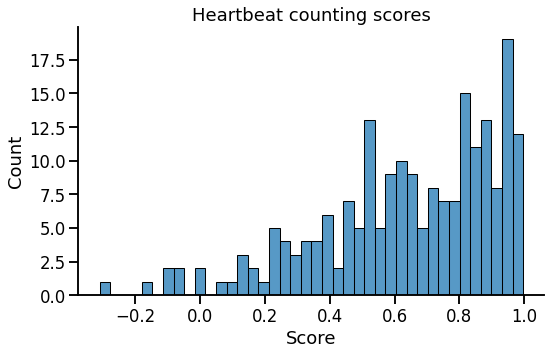

In [4]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 5))
sns.histplot(data=scores_df.groupby(['Subject'], as_index=False).mean(), x='Score', ax=ax, bins=40)
plt.tight_layout()
plt.title('Heartbeat counting scores')
sns.despine()

In [5]:
scores_df.to_csv(os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data/hbc.txt'), index=False)

# Correlations with the Heartbeat Counting task

In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
del1_df = pd.read_csv(path + '/data/Del1_psychophysics.txt')
hbc_df = pd.read_csv(path + '/data/hbc.txt')

In [7]:
# Check for outliers using MAD rule
for sub in hbc_df.Subject.unique():
    hbc_df.loc[hbc_df.Subject == sub, 'Outlier'] = pg.madmedianrule(hbc_df[hbc_df.Subject == sub].Score.to_numpy())

C:\ProgramData\Anaconda3\lib\site-packages\pingouin\nonparametric.py:145: RuntimeWarning: divide by zero encountered in true_divide
  return (np.fabs(a - np.median(a)) / mad(a)) > k
C:\ProgramData\Anaconda3\lib\site-packages\pingouin\nonparametric.py:145: RuntimeWarning: invalid value encountered in true_divide
  return (np.fabs(a - np.median(a)) / mad(a)) > k


In [8]:
summary_df = pd.merge(del1_df, hbc_df[hbc_df.Outlier==False].groupby(['Subject']).mean(), on=['Subject'])

In [9]:
summary_df.Subject.nunique()

193

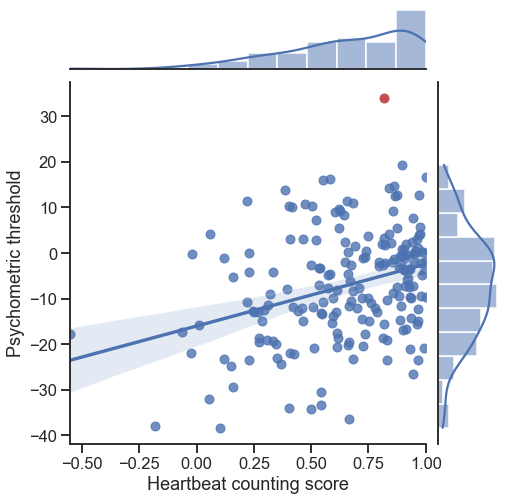

In [10]:
sns.set(style="white", color_codes=True)
sns.set_context('talk')

_, _, outliers = pg.correlation.skipped(
    y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
    x=summary_df['Score'][summary_df.Modality=='Intero'].to_numpy())

g = sns.jointplot(
    y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy()[~outliers], 
    x=summary_df['Score'][summary_df.Modality=='Intero'].to_numpy()[~outliers],
    kind='reg', height=7)

g.ax_joint.plot(summary_df['Score'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                'ro')

g.ax_joint.tick_params(axis='both', which='major', bottom=True, left=True)
g.ax_joint.set_ylabel('Psychometric threshold')
g.ax_joint.set_xlabel('Heartbeat counting score')
plt.savefig(path + '/figures/Fig5_HBC_corr.svg', dpi=300)

In [11]:
pg.corr(y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
        x=summary_df['Score'][summary_df.Modality=='Intero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,193,1,0.294801,"[0.16, 0.42]",0.086907,0.077296,0.000033,0.98738


In [12]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Modality=='Extero'].to_numpy(),
        y=summary_df['Score'][summary_df.Modality=='Extero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,193,13,-0.041139,"[-0.18, 0.1]",0.001692,-0.008816,0.583466,0.087701


In [13]:
summary_df = pd.merge(del1_df, hbc_df.groupby(['Subject']).sum(), on=['Subject'])

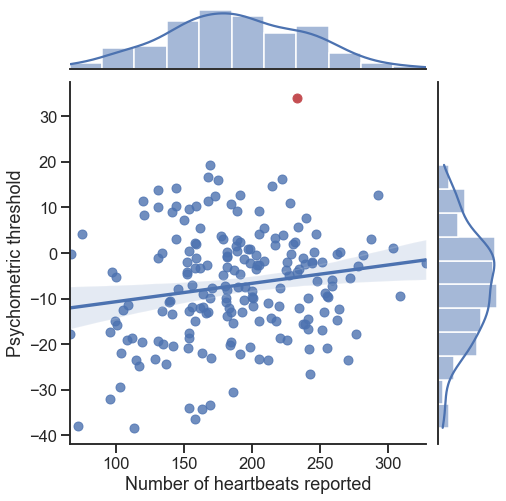

In [14]:
_, _, outliers = pg.correlation.skipped(
    y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
    x=summary_df['Reported'][summary_df.Modality=='Intero'].to_numpy())

g = sns.jointplot(
    y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy()[~outliers], 
    x=summary_df['Reported'][summary_df.Modality=='Intero'].to_numpy()[~outliers], 
    kind='reg', height=7)

g.ax_joint.plot(summary_df['Reported'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                'ro')
g.ax_joint.tick_params(axis='both', which='major', bottom=True, left=True)

g.ax_joint.set_ylabel('Psychometric threshold')
g.ax_joint.set_xlabel('Number of heartbeats reported')
plt.savefig(path + '/figures/Fig5_HBC_corr2.svg', dpi=300)

In [15]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
        y=summary_df['Reported'][summary_df.Modality=='Intero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,193,1,0.147013,"[0.01, 0.28]",0.021613,0.011314,0.041867,0.534229


In [16]:
pg.partial_corr(data=summary_df[summary_df.Modality=='Intero'], x='BayesianThreshold', y='Reported', y_covar='Counts', method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,193,2,0.205367,"[0.07, 0.34]",0.042175,0.032093,0.004371,0.820774


In [17]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Modality=='Extero'].to_numpy(),
        y=summary_df['Reported'][summary_df.Modality=='Extero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,193,5,0.007477,"[-0.13, 0.15]",0.000056,-0.01047,0.918881,0.05114


## Session 2

In [18]:
del2_df = pd.read_csv(path + '/data/Del2_psychophysics.txt')
hbc_df = pd.read_csv(path + '/data/hbc.txt')

In [19]:
# Check for outliers using MAD rule
for sub in hbc_df.Subject.unique():
    hbc_df.loc[hbc_df.Subject == sub, 'Outlier'] = pg.madmedianrule(hbc_df[hbc_df.Subject == sub].Score.to_numpy())

C:\ProgramData\Anaconda3\lib\site-packages\pingouin\nonparametric.py:145: RuntimeWarning: divide by zero encountered in true_divide
  return (np.fabs(a - np.median(a)) / mad(a)) > k
C:\ProgramData\Anaconda3\lib\site-packages\pingouin\nonparametric.py:145: RuntimeWarning: invalid value encountered in true_divide
  return (np.fabs(a - np.median(a)) / mad(a)) > k


In [20]:
summary_df = pd.merge(del2_df, hbc_df[hbc_df.Outlier==False].groupby(['Subject']).mean(), on=['Subject'])

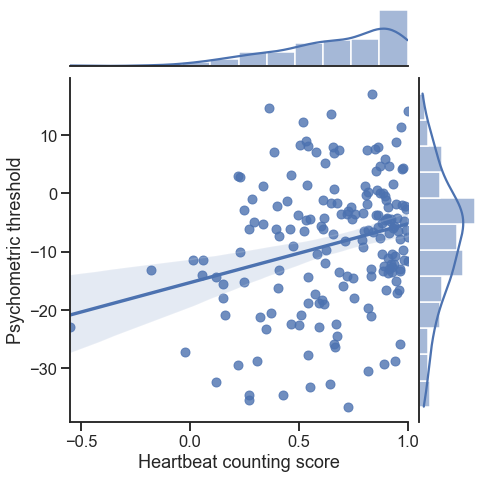

In [21]:
sns.set(style="white", color_codes=True)
sns.set_context('talk')

g = sns.jointplot(
    data=summary_df[summary_df.Modality=='Intero'],
    y='BayesianThreshold', x='Score', kind='reg', height=7)
g.ax_joint.set_ylabel('Psychometric threshold')
g.ax_joint.set_xlabel('Heartbeat counting score')

_, _, outliers = pg.correlation.skipped(
    y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
    x=summary_df['Score'][summary_df.Modality=='Intero'].to_numpy())
g.ax_joint.plot(summary_df['Score'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy()[outliers],
                'ro')
g.ax_joint.tick_params(axis='both', which='major', bottom=True, left=True)

In [22]:
pg.corr(y=summary_df['BayesianThreshold'][summary_df.Modality=='Intero'].to_numpy(),
        x=summary_df['Score'][summary_df.Modality=='Intero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,178,0,0.190984,"[0.05, 0.33]",0.036475,0.025463,0.01066,0.727178


In [23]:
pg.corr(x=summary_df['BayesianThreshold'][summary_df.Modality=='Extero'].to_numpy(),
        y=summary_df['Score'][summary_df.Modality=='Extero'].to_numpy(), method='skipped')

,n,outliers,r,CI95%,r2,adj_r2,p-val,power
skipped,178,16,-0.074471,"[-0.22, 0.07]",0.005546,-0.005819,0.34628,0.167369
